In [1]:
%load_ext watermark
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from myst_nb import glue
from IPython.display import Markdown as md

from plastockconf import name_zones, name_particles, name_frequentation, name_situation
from plastockconf import particle_groups, name_substrate, name_distance, table_css_styles, table_css_styles_top

from plastock import attribute_summary, attribute_summary_test, attribute_summary_grid, add_table_to_page

a_property =  {'color' : 'red'}
format_kwargs = dict(precision=2, thousands="'", decimal=",")
glue('blank_caption', " ", display=False)

section = 'A'
page = 2

work_data = pd.read_csv("data/end_pipe/long_form_micro.csv")
work_data.rename(columns={'echantillon':'échantillon', 'frequentation':'fréquentation'}, inplace=True)
beach_data = pd.read_csv("data/end_pipe/asl_beaches.csv")

In [2]:
table_no = 1
figure_no = 1

caption = 'Les données d\'analyse. Tous les tableaux et figures sont construits à partir de cet ensemble de données.'
rule = 'Les attributs dont la moyenne des résultats est supérieure à la moyenne du projet sont en rouge.'

t_0 = work_data.head().style.set_table_styles(table_css_styles)
table_0 = add_table_to_page(t_0, table_no, caption, section, page, rule, format_index='columns')
glue('tablea21', table_0, display=False)

In [3]:
# ! combine souples et dur !
fibers = work_data.loc[work_data.objet == 'fibres'].copy()
not_fibers = work_data.loc[work_data.objet != 'fibres'].copy()

not_fibers['objet'] = 'fragments'

work_datai = pd.concat([fibers, not_fibers])

Text(0.5, 0, 'X')

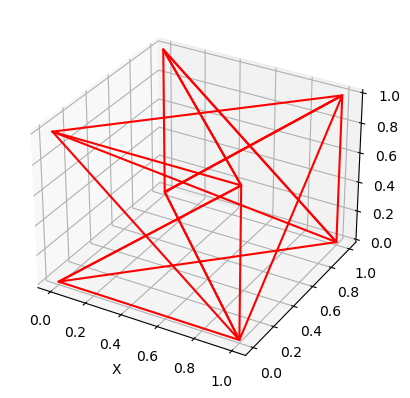

In [25]:
# First initialize the fig variable to a figure
fig = plt.figure()
# Add a 3d axis to the figure
ax = fig.add_subplot(111, projection='3d')
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

 
vertices = np.zeros([3,8],dtype=int)
vertices[0,:] = [1, 7, 5, 8, 2, 4, 6, 3]
vertices[1,:] = [1, 7, 4, 6, 8, 2, 5, 3]
vertices[2,:] = [6, 1, 5, 2, 8, 3, 7, 4]
vertices = vertices - 1 #(adjust the indices by one since python starts with zero indexing)

# Define an array with dimensions 8 by 3
# 8 for each vertex
# -> indices will be vertex1=0, v2=1, v3=2 ...
# 3 for each coordinate
# -> indices will be x=0,y=1,z=1
cube = np.zeros([8,3])

# Define x values
cube[:,0] = [0, 0, 0, 0, 1, 1, 1, 1]
# Define y values
cube[:,1] = [0, 1, 0, 1, 0, 1, 0, 1]
# Define z values
cube[:,2] = [0, 0, 1, 1, 0, 0, 1, 1]
faces = []
faces.append(np.zeros([5,3]))
faces.append(np.zeros([5,3]))
faces.append(np.zeros([5,3]))
faces.append(np.zeros([5,3]))
faces.append(np.zeros([5,3]))
faces.append(np.zeros([5,3]))
# Bottom face
faces[0][:,0] = [0,0,1,1,0]
faces[0][:,1] = [0,1,1,0,0]
faces[0][:,2] = [0,0,0,0,0]
# Top face
faces[1][:,0] = [0,0,1,1,0]
faces[1][:,1] = [0,1,1,0,0]
faces[1][:,2] = [1,1,1,1,1]
# Left Face
faces[2][:,0] = [0,0,0,0,0]
faces[2][:,1] = [0,1,1,0,0]
faces[2][:,2] = [0,0,1,1,0]
# Left Face
faces[3][:,0] = [1,1,1,1,1]
faces[3][:,1] = [0,1,1,0,0]
faces[3][:,2] = [0,0,1,1,0]
# front face
faces[4][:,0] = [0,1,1,0,0]
faces[4][:,1] = [0,0,0,0,0]
faces[4][:,2] = [0,0,1,1,0]
# front face
faces[5][:,0] = [0,1,1,0,0]
faces[5][:,1] = [1,1,1,1,1]
faces[5][:,2] = [0,0,1,1,0]
# ax.add_collection3d(Poly3DCollection(faces, facecolors='cyan', linewidths=1, edgecolors='k', alpha=.25))


# ax.plot(cube[vertices[0,:],0],cube[vertices[0,:],1],cube[vertices[0,:],2],color='r')
# ax.plot(cube[vertices[1,:],0],cube[vertices[1,:],1],cube[vertices[1,:],2],color='r')
# ax.plot(cube[vertices[2,:],0],cube[vertices[2,:],1],cube[vertices[2,:],2],color='r')
ax.plot(cube
ax.set_xlabel('X')

In [30]:
cube

array([[0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 1.],
       [1., 0., 0.],
       [1., 1., 0.],
       [1., 0., 1.],
       [1., 1., 1.]])

In [35]:
cube[vertices[0]]

array([[0., 0., 0.],
       [1., 0., 1.],
       [1., 0., 0.],
       [1., 1., 1.],
       [0., 1., 0.],
       [0., 1., 1.],
       [1., 1., 0.],
       [0., 0., 1.]])

In [34]:
vertices[0, :]

array([0, 6, 4, 7, 1, 3, 5, 2])

In [4]:
# def name_the_new_distance(x, less='<= 500 m', more = '> 500 m'):
#     if x == 1:
#         return less
#     else:
#         return more

# def name_the_new_freq(x, new):
#     if x <= 2:
#         return new
#     else:
#         return 'Elévée'


# # the feature variables are added to the work_data
# ti = work_data.copy()
# features = ['frequentation', 'situation', 'orientation', 'distance']

# beach_datax = pd.read_csv("data/end_pipe/asl_beaches.csv").set_index('Plage')

# # they can be merged on the Plage column and the index
# env_plastock = ti.merge(beach_datax[features], left_on='Plage', right_index=True)

# # ! creation of composite variables !
# t_and_f = env_plastock.loc[:, ['échantillon', 'slug','date','code', 'pcs/m²', 'quantité', 'frequentation', 'situation', 'distance', 'substrat']].copy()


# # the substrat and distance features are being combined
# # the two lowest and the two highest of each group are being combined
# # substrat is a matter of combining different granularities. They are being grouped as
# # sand and gravel.
# # distance is now grouped by locations either less than or equal to 500 meters
# t_and_f.loc[t_and_f.substrat <= 2, 'substrat'] = 1
# t_and_f.loc[t_and_f.substrat > 2, 'substrat'] = 2
# t_and_f.loc[t_and_f.distance <= 2, 'distance'] = 1
# t_and_f.loc[t_and_f.distance > 2, 'distance'] = 2
# t_and_f.loc[t_and_f.frequentation <= 2, 'frequentation'] = 2

# # ! the data used in the models !
# f_combi = t_and_f.copy()



# f_combi.rename(columns={'frequentation':'fréquentation', 'loc_date': 'échantillon'}, inplace=True)

# # the feature variables are combined along the ordinal axis. Going from four catgories
# # to two in the case of distance and substrate. city and country are already binary
# # the values of low and moderate frequentation are combined also.
# f_comb = f_combi.copy()
# f_comb['distance'] = f_comb['distance'].apply(lambda x: name_the_new_distance(x))
# f_comb['fréquentation'] = f_comb['fréquentation'].apply(lambda x: name_the_new_freq(x, 'faible-moyenne'))
# f_comb['situation'] = f_comb['situation'].apply(lambda x: name_situation[x])
# f_comb['substrat'] = f_comb['substrat'].apply(lambda x: name_the_new_distance(x, less='Sable', more='Graviers'))


# # ! no composite variables !
# no_combined = env_plastock.loc[:, ['échantillon', 'slug','date','code', 'pcs/m²', 'frequentation', 'situation', 'distance', 'substrat']].copy()
# no_combined.rename(columns={'frequentation':'fréquentation', 'loc_date': 'échantillon'}, inplace=True)

# no_combined['distance'] = no_combined['distance'].apply(lambda x: name_distance[x])
# no_combined['fréquentation'] = no_combined['fréquentation'].apply(lambda x: name_frequentation[x])
# no_combined['situation'] = no_combined['situation'].apply(lambda x: name_situation[x])
# no_combined['substrat'] = no_combined['substrat'].apply(lambda x: name_substrate[x])

In [138]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder



def analyze_scenario(scenario_data, func, n_iterations=100, bin_width=0.2):
    """
    Analyze a specific scenario using Random Forest regression with bootstrapping,
    and calculate feature importances.

    :param data: DataFrame containing the dataset.
    :param feature_1: The name of the first feature for filtering.
    :param feature_1_value: The value of the first feature to filter by.
    :param feature_2: The name of the second feature for filtering.
    :param feature_2_value: The value of the second feature to filter by.
    :param n_iterations: Number of bootstrap iterations. Default is 100.
    :param bin_width: Width of each bin for histogram. Default is 0.2.
    :return: A tuple containing bins, bin probabilities, flattened predictions, and feature importances.
    """
    
    # Prepare data for regression
    y_scaler = MinMaxScaler()
    y_scaled = y_scaler.fit_transform(scenario_data['pcs_m'].values.reshape(-1,1)).flatten()
    
    # Initialize the OneHotEncoder
    # here we encode the ordinal data
    encoder = OneHotEncoder(sparse_output=False)
    
    X = scenario_data.drop('pcs_m', axis=1)
    
    # Apply the encoder to the categorical columns
    encoded_data = encoder.fit_transform(scenario_data[['fréquentation', 'situation', 'distance', 'substrat']])
    # Create a DataFrame with the encoded data
    X_encoded = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['fréquentation', 'situation', 'distance', 'substrat']))

    
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_scaled, test_size=0.1, random_state=42)

    # Bootstrap predictions and accumulate feature importances
    bootstrap_predictions = []
        
    # Collect diagnostic at each repetition
    cum_mse = []
    cum_r2 = []
    
    for _ in range(n_iterations):
        X_train_sample, y_train_sample = resample(X_train, y_train, n_samples= len(y_train) -1)
        rf_model_sample = func
        rf_model_sample.fit(X_train_sample, y_train_sample)
        
        pred = rf_model_sample.predict(X_test)
        
        r2 = r2_score(y_test, pred)
        pred = y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
        bootstrap_predictions.append(pred)
        mse = mean_squared_error(y_test , pred)
        
        cum_mse.append(mse)
        cum_r2.append(r2)           

    # Flatten the predictions array
    predictions_flat = np.array(bootstrap_predictions).flatten()
    
    return predictions_flat, cum_mse, cum_r2

def plot_histogram(predictions, observed, title="", reference='camp-dist-1', display=False, order='predictions', xmax=20, n_bins=20, x_label='pcs/m³'):
    
    fig, ax = plt.subplots(figsize=(10, 6))
    if order == 'predictions':
        sns.histplot(predictions, bins=n_bins, stat="probability", ax=ax, label='prédictions', zorder=0)
        sns.histplot(observed, bins=n_bins, stat="probability", label='observée', zorder=1, ax=ax)
    else:
        sns.histplot(predictions, bins=n_bins, stat="probability", ax=ax, label='prédictions', zorder=1)
        sns.histplot(observed, bins=n_bins, stat="probability", label='observée', zorder=0, ax=ax)
    ax.set_xlim(-.1, np.quantile(observed, .95))
    plt.title(title, loc='left')
    plt.xlabel(x_label)
    plt.ylabel('Densité de Probabilité')
    plt.legend()
    glue(reference, fig, display=display)
    plt.close()

def evalutate_model(r2s, mses, label, model='random-forest'):
    r2 = np.round(np.mean(r2s), 2)
    mse = np.round(np.mean(mses), 2)
    results = {"cross validated error":r2, "mean² error":mse, 'model':model}
    return pd.DataFrame(results, index=[label])

# Calculating quantiles for Scenario 2
format_kwargs = dict(precision=0, thousands="'")
q_uants = [0.01, 0.25, 0.5, 0.75, 0.99]
index = ['1%', '25%', '50%', '75%', '99%', 'Moyenne']
def makeqdf(observed, predicted, index=index, quants=q_uants, caption=""):
    
    o_q = np.quantile(observed, quants)
    m_o = np.mean(observed)
    o_p = np.quantile(predicted, quants)
    m_p = np.mean(predicted)
    
    results = {'observée':[*o_q, m_o], 'prédiction': [*o_p, m_p]}
   
    return pd.DataFrame(results, index=index).style.set_table_styles(table_css_styles_top).format(**format_kwargs).set_caption(caption)

cols = ['échantillon', 'position', 'fréquentation','situation', 'distance', 'substrat']

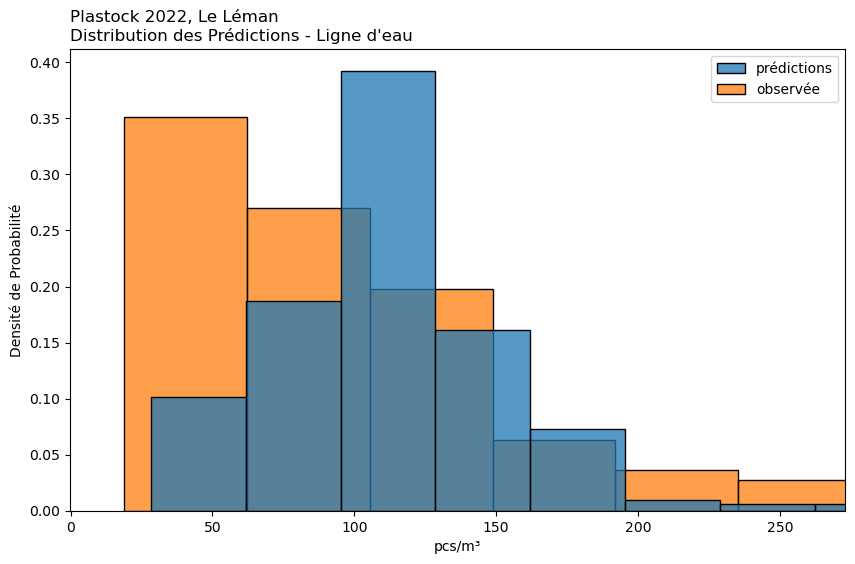

In [239]:
# model parameters
estimators = 10
iterations = 100

test_xt = work_datai.copy()
# the volume of the container used to sample in cm³
sample_volume_cm = 10*10*5
sample_volume_m = sample_volume_cm/10**6
test_xt['pcs_m'] = test_xt['compte']


# Filter for Scenario 
test_xi = test_xt[(test_xt['position'] == 1)].copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()

test_x = test_x[['fréquentation', 'situation', 'distance', 'substrat',  'pcs_m']]

func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42)
predictions, mse, r2 = analyze_scenario(test_x, func,  n_iterations=iterations, bin_width=0.2)

caption = 'Ligne d\'eau'
q_sit_2_freq_3 = makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q-lignedeau-sa', q_sit_2_freq_3, display=False)

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions - Ligne d\'eau'
plot_histogram(predictions, test_x.pcs_m.values, title=title, reference='lignedeau-sa', display=True, order="observed")

Index(['fréquentation', 'situation', 'distance', 'substrat'], dtype='object')
Index(['fréquentation', 'situation', 'distance', 'substrat'], dtype='object')


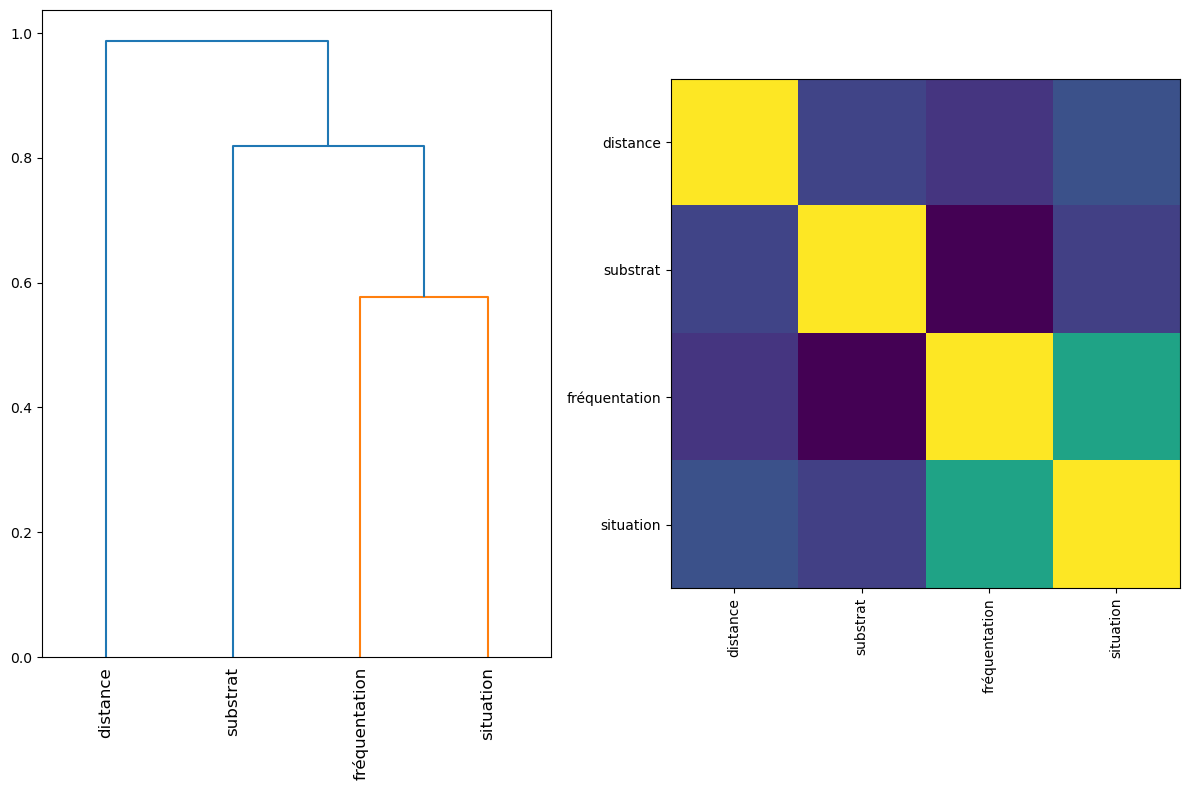

In [229]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from collections import defaultdict
from sklearn.inspection import permutation_importance

def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=2)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

test_xt = work_datai.copy()
# the sides of the object used to sample
test_xt['pcs_m'] = (test_xt['compte']/100)*10000

 # Prepare data for regression
scenario_data = test_x.copy()
scenario_data.reset_index(inplace=True, drop=True)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(scenario_data['pcs_m'].values.reshape(-1,1)).flatten()

# Initialize the OneHotEncoder
# here we encode the ordinal data
encoder = OneHotEncoder(sparse_output=False)

X = scenario_data.drop('pcs_m', axis=1)
print(X.columns)

# Apply the encoder to the categorical columns
# encoded_data = encoder.fit_transform(scenario_data[['fréquentation', 'distance', 'substrat']])
# Create a DataFrame with the encoded data
# X_encoded = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['fréquentation', 'distance', 'substrat']))
# X_encoded["Plage"] = scenario_data.Plage


X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)

cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features_names = X.columns[selected_features]
print(selected_features_names)

X_train_sel = X_train[selected_features_names]
X_test_sel = X_test[selected_features_names]

clf_sel = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42)
clf_sel.fit(X_train_sel, y_train)
print(
    "Baseline accuracy on test data with features removed:"
    f" {clf_sel.score(X_test_sel, y_test):.2}"
)

selected_features_names

Index(['fréquentation'], dtype='object')
Baseline accuracy on test data with features removed: 0.037


Index(['fréquentation'], dtype='object')

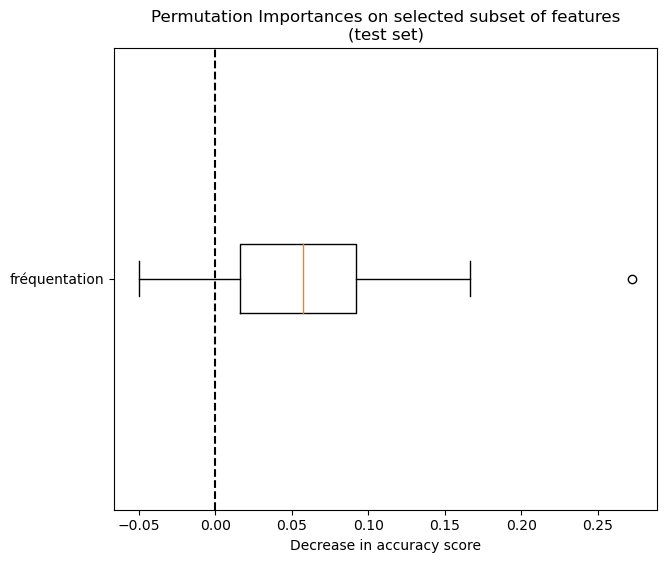

In [237]:
fig, ax = plt.subplots(figsize=(7, 6))
ax = plot_permutation_importance(clf_sel, X_test_sel, y_test, ax)
ax.set_title("Permutation Importances on selected subset of features\n(test set)")
ax.set_xlabel("Decrease in accuracy score")
plt.show()

In [71]:
# feat_importances = pd.DataFrame(feature_importance, index=imp_cols, columns=["Importance"])

# feat_importances = feat_importances.sort_values(by="Importance", ascending=False)

# fig, ax = plt.subplots()

# sns.barplot(feat_importances, y=feat_importances.index, x="Importance", ax=ax)
# ax.tick_params(which='both', axis='x', labelrotation=45)
# ax.set_title("Importance des variables, postion = Ligne d'eau", loc='left')
# plt.tight_layout()
# plt.savefig('variable_importance.png')
# plt.show()

In [8]:
# Filter for Scenario 

cols = ['échantillon', 'position', 'fréquentation','situation', 'distance', 'substrat']
test_xi = test_xt.copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()

test_x = test_x[['fréquentation', 'situation', 'distance', 'substrat',  'pcs_m']]

func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42)
predictions, feature_importance, mse, r2, imp_cols, x, y = analyze_scenario(test_x, func,  n_iterations=iterations, bin_width=0.2)

caption = 'Ligne d\'eau'
q_sit_2_freq_3 = makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q-tous-md-sa', q_sit_2_freq_3, display=False)

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions - Ligne d\'eau'
plot_histogram(predictions, test_x.pcs_m.values, title=title, reference='tous-md-sa', display=False, order="observed")

In [9]:
# Filter for Scenario 
test_xi = test_xt[(test_xt['position'] == 2)].copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()

test_x = test_x[['fréquentation', 'situation', 'distance', 'substrat', 'pcs_m']]

func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42)
predictions, feature_importance, mse, r2, imp_cols, x, y = analyze_scenario(test_x, func,  n_iterations=iterations, bin_width=0.2)

caption = 'Plage seche'
q_sit_2_freq_3 = makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q-plageseche-sa', q_sit_2_freq_3, display=False)

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions - Plage seche'
plot_histogram(predictions, test_x.pcs_m.values, title=title, reference='plageseche-sa', display=False, order="observed")

In [10]:
# Filter for Scenario 
cols = ['échantillon', 'position', 'fréquentation','situation', 'distance', 'substrat']
test_xi = test_xt[(test_xt['position'] == 2)&(test_xt.objet == 'fibres')].copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()

test_x = test_x[['fréquentation', 'situation', 'distance', 'substrat', 'pcs_m']]

func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42)
predictions, feature_importance, mse, r2, imp_cols, x, y = analyze_scenario(test_x, func,  n_iterations=iterations, bin_width=0.2)

caption = 'Plage seche et fibres'
q_sit_2_freq_3 = makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q-plagesechefibres-sa', q_sit_2_freq_3, display=False)

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions - Plage seche et fibres'
plot_histogram(predictions, test_x.pcs_m.values, title=title, reference='plagesechefibres-sa', display=False, order="observed")

In [11]:
# Filter for Scenario 
test_xi = test_xt[(test_xt['substrat'] == 1)].copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()

test_x = test_x[['fréquentation', 'situation', 'distance', 'substrat', 'pcs_m']]

func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42)
predictions, feature_importance, mse, r2, imp_cols, x, y = analyze_scenario(test_x, func,  n_iterations=iterations, bin_width=0.2)

caption = 'Sables fins'
q_sit_2_freq_3 = makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q-sablesfins-sa', q_sit_2_freq_3, display=False)

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions - Sables fins'
plot_histogram(predictions, test_x.pcs_m.values, title=title, reference='sablesfins-sa', display=False, order="observed")

In [12]:
# Filter for Scenario 
test_xi = test_xt[(test_xt['substrat'] == 4)].copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()

test_x = test_x[['fréquentation', 'situation', 'distance', 'substrat', 'pcs_m']]

func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42)
predictions, feature_importance, mse, r2, imp_cols, x, y = analyze_scenario(test_x, func,  n_iterations=iterations, bin_width=0.2)

caption = 'Cailloux'
q_sit_2_freq_3 = makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q-cailloux-sa', q_sit_2_freq_3, display=False)

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions - Cailloux'
plot_histogram(predictions, test_x.pcs_m.values, title=title, reference='cailloux-sa', display=False, order="observed")

In [13]:
# Filter for Scenario 
test_xi = test_xt[(test_xt['fréquentation'] == 3)].copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()

test_x = test_x[['fréquentation', 'situation', 'distance', 'substrat', 'pcs_m']]

func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42)
predictions, feature_importance, mse, r2, imp_cols, x, y = analyze_scenario(test_x, func,  n_iterations=iterations, bin_width=0.2)

caption = 'Fréquentation élevée'
q_sit_2_freq_3 = makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q-freq3-sa', q_sit_2_freq_3, display=False)

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions - Fréquentation élevée'
plot_histogram(predictions, test_x.pcs_m.values, title=title, reference='freq3-sa', display=False, order="observed")

In [14]:
# Filter for Scenario 
test_xi = test_xt[(test_xt['fréquentation'] == 2)].copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()

test_x = test_x[['fréquentation', 'situation', 'distance', 'substrat', 'pcs_m']]

func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42)
predictions, feature_importance, mse, r2, imp_cols, x, y = analyze_scenario(test_x, func,  n_iterations=iterations, bin_width=0.2)

caption = 'Fréquentation moyenne'
q_sit_2_freq_3 = makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q-freq2-sa', q_sit_2_freq_3, display=False)

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions - Sables fins'
plot_histogram(predictions, test_x.pcs_m.values, title=title, reference='freq2-sa', display=False, order="observed")

# Micros particules 

__Format__ 

Le format suit celui de l'annexe pour les [microplastiques](micro_atts) . Nous incluons également l'analyse utilisant des variables combinées selon la méthode décrite dans la section [Résultats précédents](previous_results).

__Le système de mesure.__

Dans cette section, les unités sont des déchets par mètre² de rivage: (pcs/m²)

## Resumé des résultats


### Autres campganes études





### Différences entre les types de plage


## Situation

::::{grid}

:::{grid-item}

resumé de [microplastiques](micro_atts) table A1-4 and Fig 3

avec détail du table A1-5

:::

:::{grid-item}
Dates d'echantillonage
:::
::::

(random_forest_sa_md)=
### Random Forest 

Source : [scikit-learn random forest](https://scikit-learn.org/0.16/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

criterion : `absolute error`

La régression avec forêt aléatoire est une technique d'apprentissage automatique (machine learning) utilisée pour prédire des résultats continus (par opposition aux catégories dans la classification). C'est une méthode d'apprentissage ensembliste, ce qui signifie qu'elle combine les prédictions de plusieurs algorithmes d'apprentissage automatique pour produire des prédictions plus précises.

::::{tab-set}

:::{tab-item} Toutes les conditions
{glue}`tous-md-sa`
:::

:::{tab-item} Fréquentation moyenne
{glue}`freq2-sa`
:::

:::{tab-item} Haute fréquentation
{glue}`freq3-sa`
:::

:::{tab-item} Cailloux
{glue}`cailloux-sa`
:::

:::{tab-item} Sables fins
{glue}`sablesfins-sa`
:::

:::{tab-item} Plage seche et sable fins
{glue}`plagesechefibres-sa`

:::

:::{tab-item} Plage seche
{glue}`plageseche-sa`

:::

:::{tab-item} Ligne d'eau
{glue}`lignedeau-sa`

:::


:::{tab-item} Résultats
:selected:

````{grid} 1 2 2 2

```{grid-item}
{glue}`q-tous-md-sa`
```

```{grid-item}

Les modèles ont fait l'objet d'un bootstrap, 100 itérations pour chaque scénario. Les résultats estimés sont la collection de toutes les prédictions de chaque itération.

Par exemple, le tableau intitulé "Gravier" présente les résultats observés et prévus pour les plages ayant un substrat de 3 ou 4.

```

```{grid-item}
{glue}`q-freq2-sa`
```

```{grid-item}
{glue}`q-freq3-sa`
```

```{grid-item}
{glue}`q-cailloux-sa`
```

```{grid-item}
{glue}`q-sablesfins-sa`
```

```{grid-item}
{glue}`q-plagesechefibres-sa`
```

```{grid-item}
{glue}`q-plageseche-sa`
```

```{grid-item}
{glue}`q-lignedeau-sa`
```

````
:::

::::
    


## Substrat

Le substrat définit la surface de l'emplacement d'échantillonnage.

In [15]:
%watermark --iversions -b -r

Git repo: https://github.com/hammerdirt-analyst/plastock.git

Git branch: dec20

seaborn   : 0.12.2
pandas    : 2.0.0
matplotlib: 3.7.1
numpy     : 1.24.2

